<a href="https://colab.research.google.com/github/tarunmannava/Homeworks/blob/main/Fair_ML_HW_1_Tarun_Mannava.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import sklearn
import pandas as pd
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from collections import defaultdict
import copy

In [ ]:
STUDENT_ID =  57125943

In [ ]:
def make_dataset(student_id = STUDENT_ID):
    X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,flip_y=0,
                               n_informative=2, n_clusters_per_class=1, class_sep=5.0,
                               random_state=student_id)
    selected_indices = [i for i, val in enumerate(y) if val == 1]
    rejected_indices = [i for i, val in enumerate(y) if val == 0]
    group_a_selected = int(len(selected_indices) * 0.56)
    group_b_rejected = int(len(rejected_indices) * 0.57)
    G = np.full(len(y),'Group A', dtype=object)

    G[selected_indices[group_a_selected:]] = "Group B"
    G[rejected_indices[:group_b_rejected]] = "Group B"

    return X, y, G




X, y, G = make_dataset() #X is the dataset, y are the ground truth labels, and G are the protected group labels


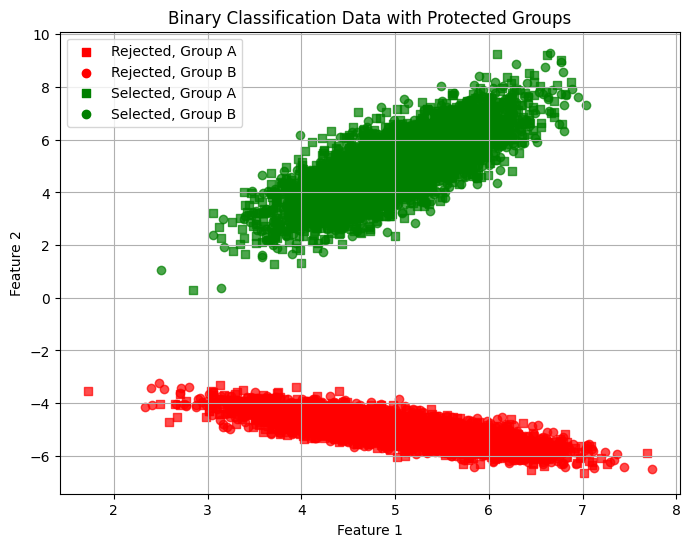

In [ ]:
def make_plot(X, y, G):
    plt.figure(figsize=(8, 6))
    for group in ['Group A', 'Group B']:
        for result in [0, 1]:
            points = (G == group) & (y == result)
            marker = 's' if group == 'Group A' else 'o'
            color = 'red' if result == 0 else 'green'
            plt.scatter(X[points, 0], X[points, 1], c=color, marker=marker, alpha=0.7)
    plt.scatter([], [], c='red', marker='s', label='Rejected, Group A')
    plt.scatter([], [], c='red', marker='o', label='Rejected, Group B')
    plt.scatter([], [], c='green', marker='s', label='Selected, Group A')
    plt.scatter([], [], c='green', marker='o', label='Selected, Group B')

    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Binary Classification Data with Protected Groups')
    plt.legend()
    plt.grid(True)
    plt.show()
make_plot(X,y,G)

In [ ]:
def train_logistic_regression(X,y):
    """TO-DO"""
    model = LogisticRegression()
    model.fit(X, y)
    predictions = model.predict(X)
    accuracy = accuracy_score(y, predictions)
    print(f'Training Accuracy: {accuracy:.4f}')
    return model



model = train_logistic_regression(X,y) #Obtain trained LR model

Training Accuracy: 1.0000


In [ ]:
def demographic_parity(predictions, G):
    """Calculate the demographic parity difference from scratch."""
    a_index=[]
    b_index=[]
    for i in range(len(G)):
      if(G[i]=='Group A'):
        a_index.append(i)
      else:
        b_index.append(i)
    group_selected=[0,0]
    for i in a_index:
      if(predictions[i]==1):
        group_selected[0]+=1
    for i in b_index:
      if(predictions[i]==1):
        group_selected[1]+=1

    dp=abs(group_selected[0]/len(a_index)-group_selected[1]/len(b_index))
    return dp





dp = demographic_parity(model.predict(X), G)
print(f"Demographic Parity Difference: {dp}")

Demographic Parity Difference: 0.12981246718934886


In [ ]:
def balance(y_pred, X, G):
    balance_values = []
    for k in [0,1]:
        k_indexes = [i for i, val in enumerate(y_pred) if val == k]
        r_k = len(k_indexes)
        for group in ['Group A','Group B']:
            group_indexes = [i for i, val in enumerate(G) if val == group]
            r_k_g = len([i for i in k_indexes if i in group_indexes])/len(k_indexes)
            r_g_X = len(group_indexes)/len(X)
            ratio_1 = r_g_X / r_k_g
            ratio_2 = r_k_g / r_g_X
            balance_values.append(min(ratio_1, ratio_2))
    balance = min(balance_values)
    return balance



print(f"Balance: {balance(model.predict(X), X, G)}")

Balance: 0.8689153706321956


In [ ]:
def update_data(X, y, G, budget=0.1*len(X)):
    """TO-DO"""
    X, y, G = np.array(X), np.array(y), np.array(G)
    budget = int(budget)
    remove_a = [i for i in range(len(G)) if G[i] == 'Group A' and y[i] == 1][:budget//2]
    remove_b = [i for i in range(len(G)) if G[i] == 'Group B' and y[i] == 0][:budget // 2]
    X_updated, y_updated, G_updated = np.delete(X, remove_a + remove_b, axis=0), np.delete(y, remove_a + remove_b), np.delete(G, remove_a + remove_b)

    return X_updated, y_updated, G_updated



X_prime, y_prime, G_prime = update_data(X,y,G) #Obtain the new updated dataset

model_prime = train_logistic_regression(X_prime, y_prime) #Obtain the new model

print(f"New Demographic Parity Difference: {demographic_parity(model_prime.predict(X_prime), G_prime)}")
print(f"New Balance: {balance(model_prime.predict(X_prime), X_prime, G_prime)}")


Training Accuracy: 1.0000
New Demographic Parity Difference: 0.03311503749160577
New Balance: 0.9665243765445967


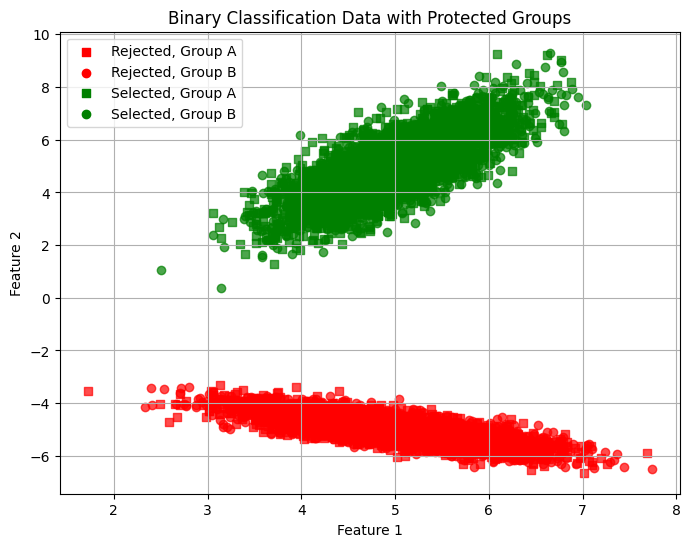

In [ ]:
make_plot(X_prime,y_prime,G_prime)